# Explore GISAID data


In [1]:
import os
import math
import pickle
import torch
from collections import Counter
from pyrocov import mutrans, pangolin
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"

## Explore columns

In [2]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("loaded {} rows".format(len(columns["day"])))
print(list(columns.keys()))

loaded 1939121 rows
['lineage', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day']


In [3]:
strain_counts = Counter(columns["lineage"])
for strain, count in strain_counts.most_common(20):
    short = pangolin.compress(strain)
    long = pangolin.decompress(strain)
    assert strain == long, (strain, long)
    if short == long:
        print(f"{count: >10d} {short}")
    else:
        print(f"{count: >10d} {short} (aka {long})")

    867396 B.1.1.7
     91965 B.1.2
     81889 B.1
     70643 B.1.177
     56966 B.1.617.2
     47276 B.1.1
     31511 P.1 (aka B.1.1.28.1)
     30256 B.1.429
     23905 B.1.351
     23487 B.1.160
     22503 B.1.526
     19574 B.1.1.519
     16989 B.1.1.214
     13401 B.1.427
     13126 B.1.258
     13076 B.1.221
     13007 B.1.177.21
     12332 D.2 (aka B.1.1.25.2)
     10751 B.1.243
     10172 B.1.526.2


Text(0.5, 1.0, 'Distribution of samples among lineages')

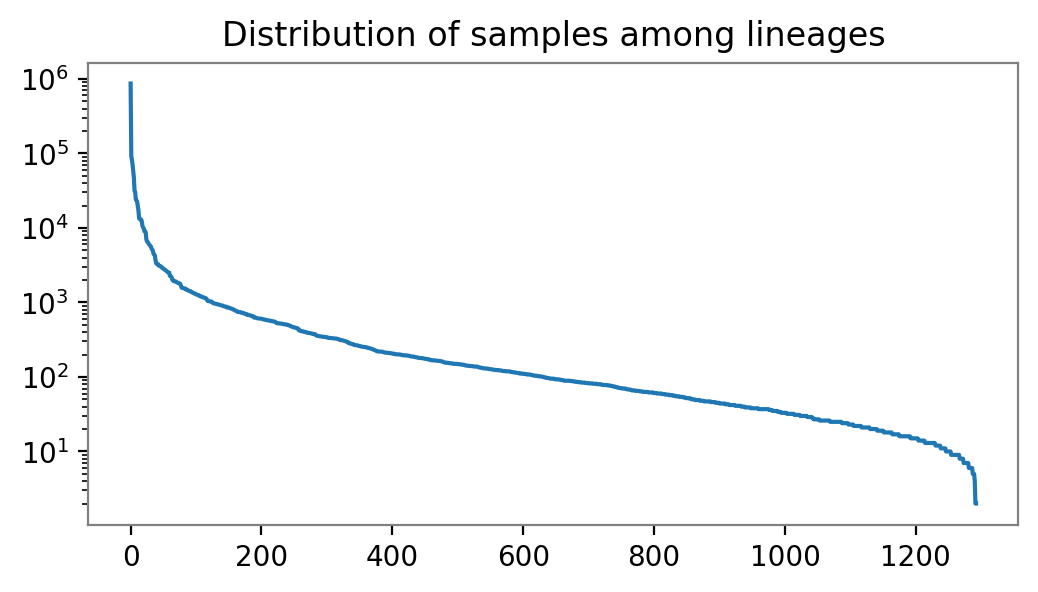

In [4]:
plt.figure(figsize=(6,3))
plt.plot([c for _, c in strain_counts.most_common()])
plt.yscale("log")
plt.title("Distribution of samples among lineages")

In [5]:
counts = Counter()
for location in columns["location"]:
    parts = location.split("/")
    if len(parts) < 2:
        continue
    parts = tuple(p.strip() for p in parts[:3])
    counts[parts] += 1

Text(0.5, 1.0, 'Distribution of samples among regions')

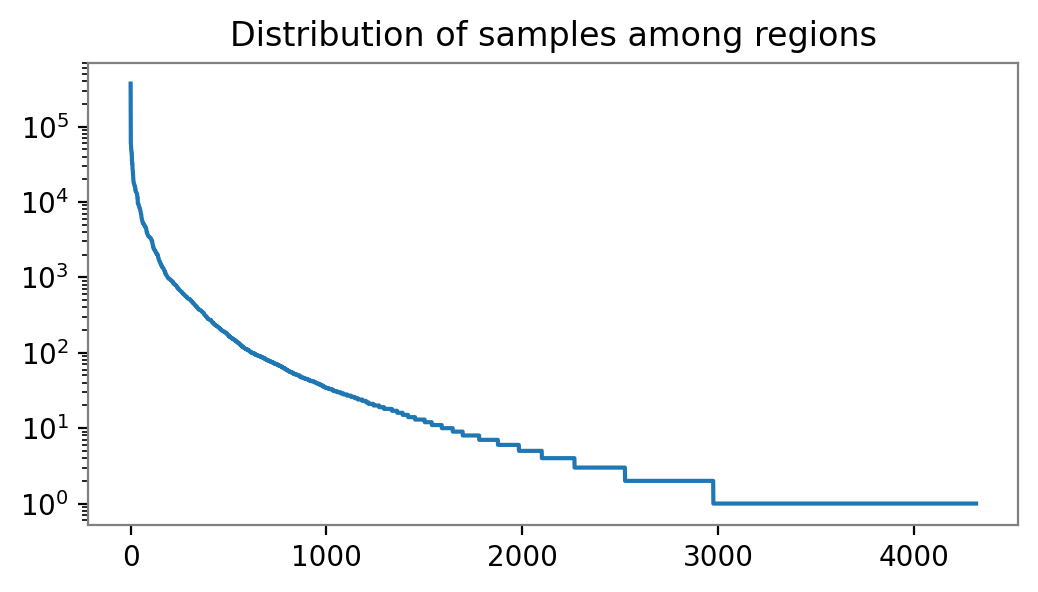

In [6]:
plt.figure(figsize=(6,3))
plt.plot([c for _, c in counts.most_common()])
plt.yscale("log")
plt.title("Distribution of samples among regions")

In [7]:
fine_countries = set()
for parts, count in counts.items():
    if count >= 5000:
        fine_countries.add(parts[1])
fine_countries = list(sorted(fine_countries))
print("\n".join(fine_countries))

Australia
Brazil
Canada
Denmark
Finland
France
Germany
Iceland
India
Ireland
Italy
Japan
Lithuania
Luxembourg
Netherlands
Norway
Portugal
Slovenia
Spain
Sweden
Switzerland
USA
United Kingdom


In [8]:
locations = Counter(columns["location"])
print("\n".join(f"{c}\t{p}" for p, c in locations.most_common() if "United Kingdom" in p))

372476	Europe / United Kingdom / England
49005	Europe / United Kingdom / Scotland
34611	Europe / United Kingdom / Wales
6965	Europe / United Kingdom / Northern Ireland
171	Europe / United Kingdom / England / South Yorkshire
107	Europe / United Kingdom / England / London
11	Europe / United Kingdom / England / Derbyshire
2	Europe / United Kingdom / England / Yorkshire / Sheffield
2	Europe / United Kingdom
1	Europe / United Kingdom / England / Northamtonshire
1	Europe / United Kingdom / England / Nottinghamhisre
1	Europe / United Kingdom / Wales / Cardiff
1	Europe / United Kingdom / England / Warwickshire
1	Europe / United Kingdom / London
1	Europe / United Kingdom / Scotland / Fraserburg


## Explore count data

In [9]:
def load_data():
    filename = "results/mutrans.data.single.pt"
    if os.path.exists(filename):
        dataset = torch.load(filename)
    else:
        dataset = mutrans.load_gisaid_data()
        torch.save(dataset, filename)
    dataset.update(mutrans.load_jhu_data(dataset))
    return dataset

dataset = load_data()
locals().update(dataset)
for k, v in sorted(dataset.items()):
    if isinstance(v, torch.Tensor):
        print(f"{k} \t{type(v).__name__} of shape {tuple(v.shape)}")
    else:
        print(f"{k} \t{type(v).__name__} of size {len(v)}")

WARNING skipping unsampled lineage C.10
WARNING skipping unsampled lineage C.17
WARNING skipping unsampled lineage C.6
WARNING skipping unsampled lineage B.1.1.400
WARNING skipping unsampled lineage B.1.316
WARNING skipping unsampled lineage B.1.1.327
WARNING skipping unsampled lineage N.8
WARNING skipping unsampled lineage B.1.324.1
WARNING skipping unsampled lineage B.1.351.1
WARNING skipping unsampled lineage N.10
WARNING skipping unsampled lineage AT.1
WARNING skipping unsampled lineage AV.1
WARNING skipping unsampled lineage B.1.617


daily_cases 	Tensor of shape (512, 980)
features 	Tensor of shape (1280, 2330)
lineage_id 	dict of size 1280
lineage_id_inv 	list of size 1280
local_time 	Tensor of shape (40, 980)
location_id 	OrderedDict of size 980
mutations 	list of size 2330
weekly_cases 	Tensor of shape (40, 980)
weekly_strains 	Tensor of shape (40, 980, 1280)


In [10]:
daily_cases.shape

torch.Size([512, 980])

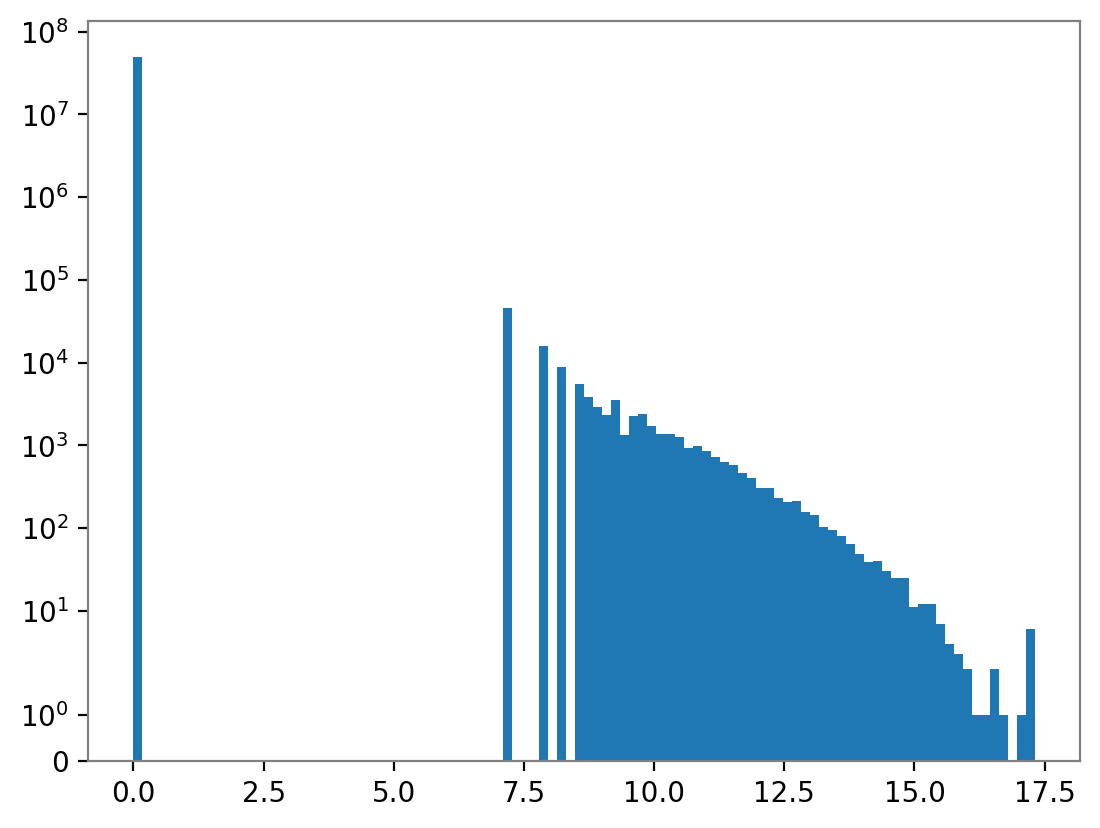

In [11]:
probs = weekly_strains + 1 / weekly_strains.size(-1)
probs /= probs.sum(-1, True)
logits = probs.log()
logits -= logits.median(-1, True).values
plt.hist(logits.reshape(-1).numpy(), bins=100)
plt.yscale("symlog");

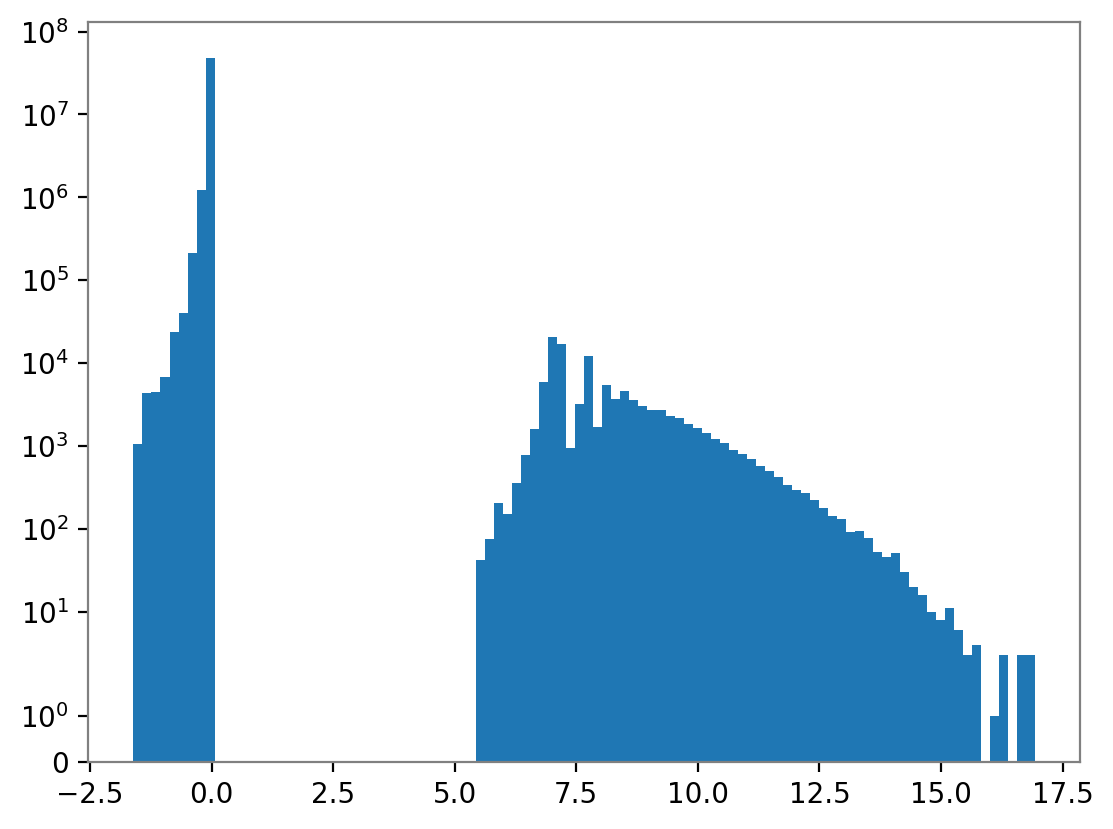

In [12]:
logits -= logits.mean(-1, True)
plt.hist(logits.reshape(-1).numpy(), bins=100)
plt.yscale("symlog");

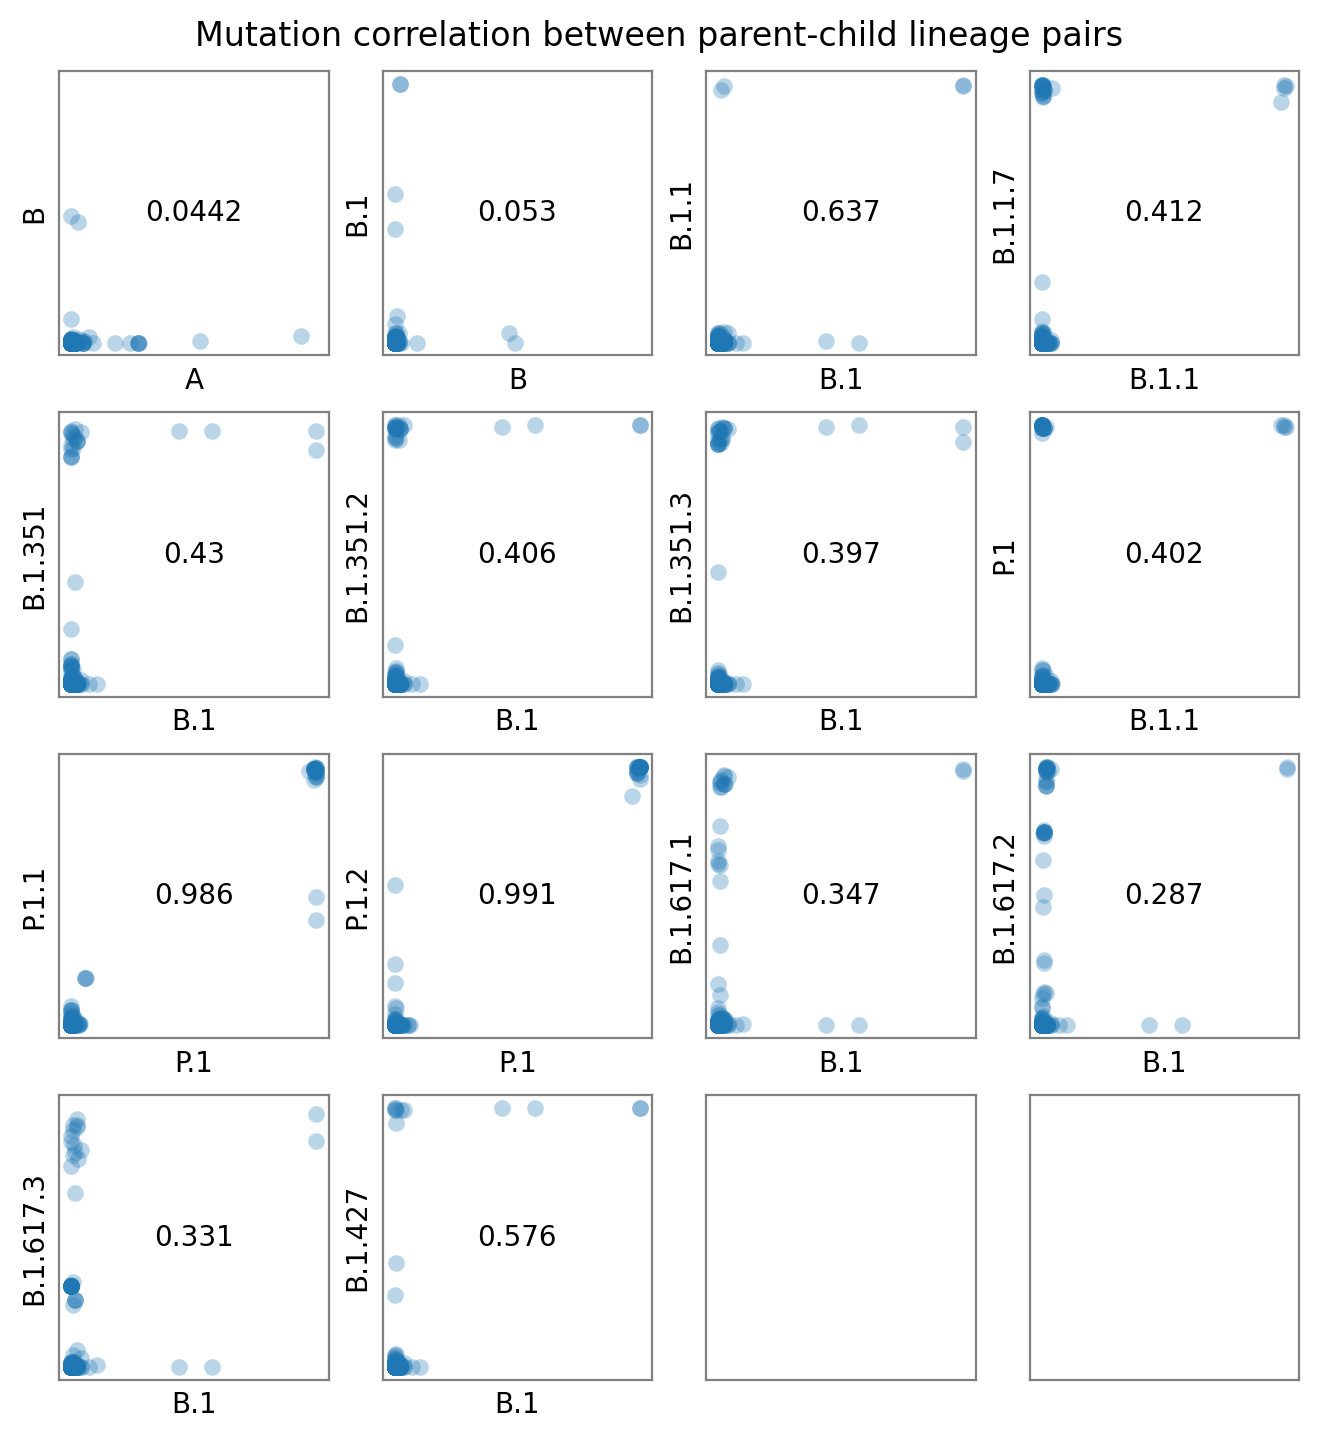

In [15]:
def plot_agreement(pairs):
    M = int(len(pairs) ** 0.5 + 0.5)
    N = int(math.ceil(len(pairs) / M))
    assert len(pairs) <= M * N
    fig, axes = plt.subplots(M, N, figsize=(2 * N, 2 * M + 0.5))
    fig.suptitle("Mutation correlation between parent-child lineage pairs", y=0.91)
    pairs = iter(pairs)
    for axe in axes:
        for ax in axe:
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_xlim(-0.05, 1.05)
            ax.set_ylim(-0.05, 1.05)
            try:
                x, y = next(pairs)
            except StopIteration:
                continue
            ax.set_xlabel(x)
            ax.set_ylabel(y)
            X = dataset["features"][dataset["lineage_id"][x]]
            Y = dataset["features"][dataset["lineage_id"][y]]
            ax.scatter(X.numpy(), Y.numpy(), alpha=0.3, lw=0)
            X = (X - X.mean()) / X.std()
            Y = (Y - Y.mean()) / Y.std()
            ax.text(0.5, 0.5, "{:0.3g}".format((X * Y).mean()),
                    va="center", ha="center")
plot_agreement([
    # Alpha
    ("A", "B"),
    ("B", "B.1"),
    ("B.1", "B.1.1"),
    ("B.1.1", "B.1.1.7"),
    # Beta
    ("B.1", "B.1.351"),
    ("B.1", "B.1.351.2"),
    ("B.1", "B.1.351.3"),
    # Gamma
    ("B.1.1", "P.1"),
    ("P.1", "P.1.1"),
    ("P.1", "P.1.2"),
    # Delta
    # ("B.1.617", "B.1.617.1"),
    # ("B.1.617", "B.1.617.2"),
    # ("B.1.617", "B.1.617.3"),
    ("B.1", "B.1.617.1"),
    ("B.1", "B.1.617.2"),
    ("B.1", "B.1.617.3"),
    # Epsilon
    ("B.1", "B.1.427"),
])